(2072, 2072, 4)


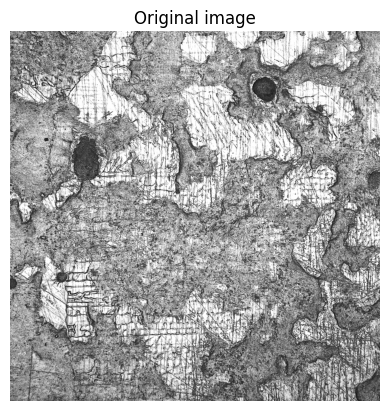

(1920, 1919, 4)


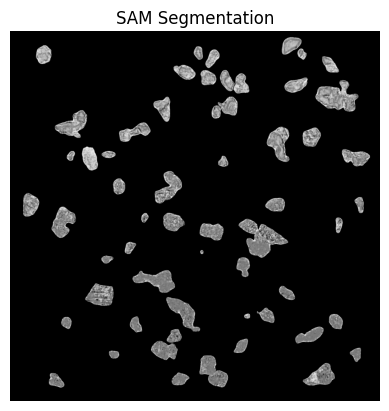

(2072, 2072, 4)


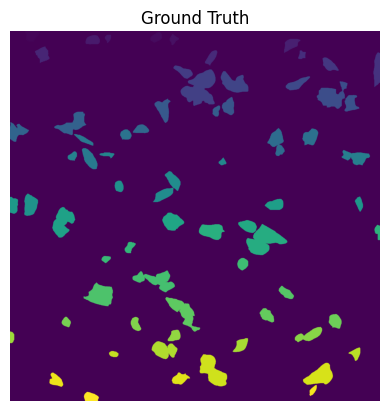

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from skimage.transform import resize


def dice_coefficient(y_true, y_pred):
    """Calcul du coefficient de Dice"""
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def IoU(y_true,y_pred):
    """Calcul du coefficient Intersection Over Union"""
    intersection=np.sum(y_true*y_pred)
    return (intersection/(np.sum(y_true)+np.sum(y_pred)-intersection)+1e-8)

PATH_IMAGE='/Users/svelasco/Downloads/dataDorian/multi_focus/'

PATH_SEGMENTATION=PATH_IMAGE+'/SAM_segmentation/'
PATH_GT=PATH_IMAGE+'/ground_truth/'

image_name='Position_0100.png'

#Only one channel is necessary (Gray scale)
image=io.imread(PATH_IMAGE+'/focused_single_slice/clean/'+image_name)
print(image.shape)
image=image[:,:,0]
plt.imshow(image,cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

segmentation=io.imread(PATH_SEGMENTATION+image_name)
print(segmentation.shape)
segmentation=segmentation[:,:,0]
plt.imshow(segmentation,cmap='gray')
plt.title('SAM Segmentation')
plt.axis('off')
plt.show()

ground_truth=io.imread(PATH_GT+image_name)
print(ground_truth.shape)
plt.imshow(ground_truth,cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

In [74]:

def binary_labeling(ground_truth):
    binary_segmentation = (ground_truth[:,:,0]==68) * (ground_truth[:,:,1]==1) * (ground_truth[:,:,2]==84)
    return 1-binary_segmentation

def binary_sam(sam):
    binary_sam = sam>0
    return binary_sam

(2072, 2072, 4)


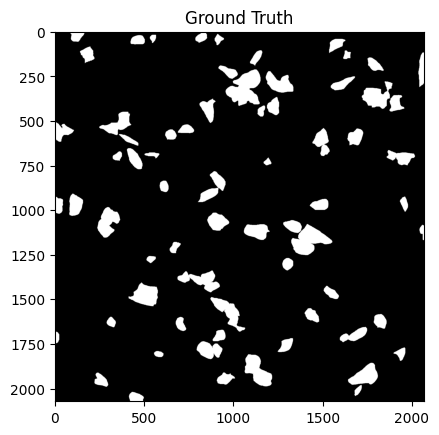

In [79]:
ground_truth=io.imread(PATH_GT+image_name)
print(ground_truth.shape)
plt.imshow(binary_labeling(ground_truth),cmap='gray')
plt.title('Ground Truth')
#plt.axis('off')
plt.show()

(1920, 1919)


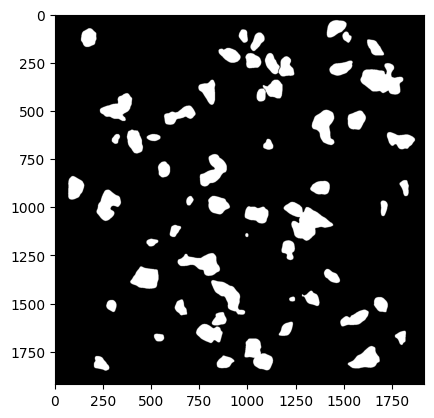

In [76]:
plt.imshow(binary_sam(segmentation),cmap='gray')
print(segmentation.shape)

In [77]:
dice_coefficient(binary_labeling(ground_truth), resize(binary_sam(segmentation),ground_truth.shape[:2],preserve_range=True))

np.float64(0.7942780110008579)

In [78]:
IoU(binary_labeling(ground_truth), resize(binary_sam(segmentation),ground_truth.shape[:2],preserve_range=True))

np.float64(0.658757184744898)